In [1]:
#@title import libraries

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import fashion_mnist

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Layer
from tensorflow.keras.metrics import Mean
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam

from tensorflow.keras import backend as K

In [2]:
#@title load data
(x_train, y_train), (_, _) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [3]:
#@title reshape data for MLP
x_train = x_train.reshape(-1, 784)

# check the shape
x_train.shape

(60000, 784)

In [4]:
#@title normalize data
x_train = x_train / 255.

In [5]:
latent_dim = 2

class Reparameterize(Layer):
    def call(self, inputs):
        z_mean, z_logvar = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        eps = K.random_normal(shape=(batch, dim))

        return z_mean + tf.exp(0.5 * z_logvar) * eps
        

class VAE(Model):
    def __init__(self):
        # layer definition
        super(VAE, self).__init__()

        self.encoder = self._create_encoder(latent_dim)
        self.decoder = self._create_decoder(latent_dim)

        self.kl_loss = Mean()
        self.reconstruction_loss = Mean()
        self.total_loss = Mean()

    def _create_encoder(self, latent_dim):
        input_layer = Input((784,))
        hidden_layer = Dense(100, activation='relu')(input_layer)
        z_mean = Dense(latent_dim)(hidden_layer)
        z_logvar = Dense(latent_dim)(hidden_layer)
        z = Reparameterize()([z_mean, z_logvar])

        return Model(input_layer, [z_mean, z_logvar, z])

    def _create_decoder(self, latent_dim):
        latent_input = Input((latent_dim,))
        hidden_layer = Dense(100, activation='relu')(latent_input)
        output_layer = Dense(784, activation='sigmoid')(hidden_layer)

        return Model(latent_input, output_layer)

    
    @property
    def metrics(self):
        return [
                self.total_loss,
                self.reconstruction_loss,
                self.kl_loss
        ]
        

    def train_step(self, inputs):
        with tf.GradientTape() as tape:
            z_mean, z_logvar, z = self.encoder(inputs)
            outputs = self.decoder(z)

            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(binary_crossentropy(inputs, outputs), axis=-1) 
            )

            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5 * (1 + z_logvar - tf.square(z_mean) - tf.exp(z_logvar)), 
                    axis=-1
                )
            )

            total_loss = reconstruction_loss + kl_loss
            grads = tape.gradient(total_loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
            self.total_loss.update_state(total_loss)
            self.reconstruction_loss.update_state(reconstruction_loss)
            self.kl_loss.update_state(kl_loss)

            return {
                "loss": self.total_loss.result(),
                "reconstruction_loss": self.reconstruction_loss.result(),
                "kl_loss": self.kl_loss.result(),
            }

In [6]:
vae_model = VAE()

In [7]:
vae_model.compile(optimizer=Adam(learning_rate=0.0001))

In [8]:
vae_model.fit(x_train, epochs=10, batch_size=128)

Epoch 1/10
469/469 [==============================] - 4s 5ms/step - loss: 83.8903 - reconstruction_loss: 82.6529 - kl_loss: 1.2375
Epoch 2/10
469/469 [==============================] - 2s 5ms/step - loss: 64.3586 - reconstruction_loss: 59.9482 - kl_loss: 4.4105
Epoch 3/10
469/469 [==============================] - 2s 5ms/step - loss: 57.8553 - reconstruction_loss: 54.0982 - kl_loss: 3.7571
Epoch 4/10
469/469 [==============================] - 2s 5ms/step - loss: 53.8306 - reconstruction_loss: 50.2583 - kl_loss: 3.5724
Epoch 5/10
469/469 [==============================] - 2s 5ms/step - loss: 52.2906 - reconstruction_loss: 48.9591 - kl_loss: 3.3315
Epoch 6/10
469/469 [==============================] - 2s 5ms/step - loss: 51.5129 - reconstruction_loss: 48.3078 - kl_loss: 3.2051
Epoch 7/10
469/469 [==============================] - 2s 5ms/step - loss: 51.0612 - reconstruction_loss: 47.9027 - kl_loss: 3.1586
Epoch 8/10
469/469 [==============================] - 2s 5ms/step - loss: 50.8299 -

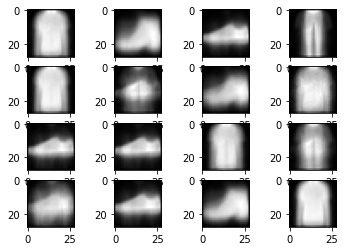

In [9]:
# generated images
random_features = np.random.uniform(-1, 1, (16, latent_dim))
gen_imgs = (np.clip(vae_model.decoder.predict(random_features), 0, 1) * 255).astype(int)

for idx, img in enumerate(gen_imgs):
    plt.subplot(4, 4, idx+1)
    plt.imshow(img.reshape((28, 28)), cmap='gray')

In [10]:
vae_model.z_means

ListWrapper([<tf.Tensor 'model/dense_1/BiasAdd:0' shape=(None, 2) dtype=float32>, <tf.Tensor 'model/dense_1/BiasAdd:0' shape=(None, 2) dtype=float32>])

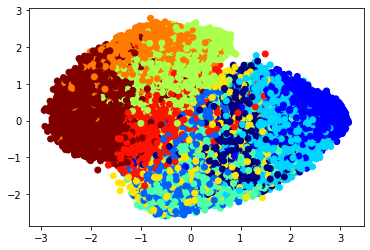

In [12]:
# plot latent space
z_mean, z_logvar, z = vae_model.encoder.predict(x_train)

plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_train, cmap='jet')

In [ ]:
(z_mean.nbytes + z_logvar.nbytes) / 1024**2

0.91552734375

In [ ]:
z.nbytes / 1024**2

0.457763671875

In [ ]:
x_train.nbytes / 1024**2

358.88671875

In [ ]:
z_mean.shape

(60000, 2)

In [ ]:
z_logvar.shape

(60000, 2)

In [ ]:
z.shape

(60000, 2)